# Cluster Model Development Synopsis
In **Expoloratory Data Analysis (EDA)** we found that the following columns are important to determine how engaged the user is with the system. **I am assuming that user engagement is the key factor in determining whether a FREE tier customer converts to a PAID customer**

### Important Variables

```
    ACTIONS_CRM_CONTACTS
    ACTIONS_CRM_COMPANIES
    ACTIONS_CRM_DEALS
    ACTIONS_EMAIL
    USERS_CRM_COMPANIES
    USERS_CRM_CONTACTS
    USERS_CRM_DEALS
    USERS_EMAIL
```    

**In the EDA, we also found that as the values of these variables increase, the probability that the activity is from a paid customer increases.**

_Q. What is **Activity** and **Current Activity**?_
>>**Activity** is nothing but any interaction of the customer with the system. The **Current Activity** is the current weekly activity of the customer based on the data from the above variables. **For all the models developed in this notebook, we will use the current activity as the input to the models (for inference)**


### Correlation

We also found that these numeric columns are correlated to each other:

```
  ACTIONS_CRM_CONTACTS <-> USERS_CRM_CONTACTS (0.81)
  ACTIONS_CRM_COMPANIES <-> USERS_CRM_COMPANIES (0.72)
  ACTIONS_CRM_DEALS <-> USERS_CRM_DEALS (0.75)
  ACTIONS_EMAIL <-> USERS_EMAIL (0.68)
  USERS_CRM_COMPANIES <-> USERS_CRM_DEALS (0.6)
```

### Imbalance
The dataset is highly imbalanced. We have only 4% conversion rate. Hence I am planning to apply an un-supervised learning algorithm to determine how engaged is a customer given their activity (based on the above columns)
**There are 200 PAID Customers and 5000 FREE Customers. So the probability of finding a PAID customer is 0.038 or 3.8%**



### What is assumed?
* We have consolidated user activity on a weekly basis. I am assuming that the user did not interact with the system, whenever there is an activity missing

* We do not have any information about the when a marketing campaign has happened, and what type of campaign has happened (as per the info provided, we have 2 different types of marketing: email based and phone based). I assumed that the marketing happened every Monday (between the dates 1/7/2019 to 8/20/2020). 

* We do not have any information about how the FREE customers are currently chosen to send the campaigns. So, I assumed that the campaign is sent to all the FREE customers till they convert.

### Model Development

#### Phase -1 (Clustering)

1. Apply **PCA (Principal Component Analysis)** on these columns
```
    ACTIONS_CRM_CONTACTS
    ACTIONS_CRM_COMPANIES
    ACTIONS_CRM_DEALS
    ACTIONS_EMAIL
    USERS_CRM_COMPANIES
```
2. Select optimal number of dimensions (**the goal is to reduce the dimensions of the dataset for visualization and also for further model development**). 

3. Select the top 2 PCA components and plot the data. Observe if the points (corresponding to levels in MEMBERSHIPTYPE) are clearly clustered.

4. Apply clustering algorithm, and select the optimal number of clusters.

5. Check how is the `MEMBERSHIPTYPE` (`FREE`, `BEFORE-PREMIUM` and `PREMIUM`) distribution in each cluster.

6. Compare the mean values of each cluster for the `ACTIONS_CRM_CONTACTS` variable.

7. Check if any cluster contains outliers.

8. Discard/Combine any clusters that contain outliers.

9. Obtain the probability distribution of each cluster for the `MEMBERSHIPTYPE` (`FREE`, `BEFORE-PREMIUM` and `PREMIUM`).

10. Define a strategy to optimally filter the FREE tier customers, given that their current activity belonging to a specific cluster.


### Insights From Cluster Model Development 

* There are some PAID customers who does NOT have any associated activity. Is this a bug? There are 16 PAID customers like that (examples: )

* The PCA has successfully captured 98% variance with 3 top components.

* The K-means clustering algorith has identified 4 customer groups. 

* **Group-1** One customer group contains user activity that is dormant (almost 0 values for the important variables listed above). If a PAID customer's activity falls into this cluster, it is high time to reach them to find out why they are NOT using the system and pro-actively address their concerns before they cancel their PREMIUM membership. We can safely avoid reaching out to FREE customers whose activity falls into this cluster for marketing needs.
    Examples: Customers with IDs: 10, 47, 77, 80, 87, 95, 144, 173, 179, 206

* **Group-2** The second cluster contains the customers activity from both PAID and FREE members. This cluster contains about 7% of the PREMIUM members activity. If a PAID member's activity falls into this cluster, then they are like an average PAID customer, and are very likely to continue their membership. If a FREE member's activity falls into this cluster, then we can reach out to them with a marketing campaign. There is a 10% chance for the customers to become a PAID member (3% to become a BEFORE-FREE member, and 7% to become a PREMIUM member directly). The average value of `ACTIONS_CRM_CONTACTS` for the members of this cluster is around 13.
    Examples: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10

* **Group-3** The third cluster contains a very limited number of customers whose activity has a high average value for `ACTIONS_CRM_CONTACTS` (around 1000). Example customer IDs: 65, 4691, 148

* **Group-4** The fourth cluster contains a extremely limited number of customers whose activity has a very high average value for `ACTIONS_CRM_CONTACTS` (> 4000). Examples: Customers with IDs: 119, 34, 67, 68, 164, 36, 39, 82, 980, 118, 5144, 187, 92

**NOTE**: Based on the customer's current week's activity, they may move from one group to another. So to smooth out this transition, it makes sense to get the average metrics (like 3 week moving average). But I did not explore this given the time constraints.


### Strategy to use Cluster Model

1. If the **Current** activity of a customer falls into **Group-1**, and if the customer is a **PAID** member, then approach the customer proactively to address their concerns

2. If the **Current** activity of a customer falls into **Group-2**, and if the customer is a **PAID** member, then ignore. If the customer is a **FREE** member, then get the predicted MRR, to determine the expected return on the customer. Based on the expected return approach the customer with one of the 2 marketing methods.

3. If the **Current** activity of a customer falls into **Group-3** or **Group-4**, check the following:
    * Is the data correct? 
    * Are the high metrics due to customer's genuine activity? If yes, reach out to the FREE customer based on the predicted MRR and average cost to obtain the customer.

# Source Code

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from util import transform_data, cat_to_num_plot
import util
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [5]:
# Read the files
# file paths
customers_file = "./customers (4).csv"
non_customers_file = "./noncustomers (4).csv"
activity_file = "./usage_actions (4).csv"


In [6]:
# Read individual files
customers_df = pd.read_csv(customers_file)
non_customers_df = pd.read_csv(non_customers_file)

# Read the combined activity file. Check STEP 1 Notebook
all_activity_df = util.transform_data(customers_file,non_customers_file,activity_file)

## Is the dataset Imbalanced?

In [310]:
len(set(customers_df["id"]))

200

In [314]:
len(set(non_customers_df["id"]))

5000

In [309]:
len(set(customers_df["id"]))/((len(set(non_customers_df["id"]))) + len(set(customers_df["id"])))

0.038461538461538464

* YES, it is highly imbalanced

## Model Development 
### Phase 1 (Clustering)

### PCA

In [12]:
# Get all numeric and important variables that we identified in EDA Phase
df = all_activity_df[['ACTIONS_CRM_CONTACTS', 'ACTIONS_CRM_COMPANIES', 'ACTIONS_CRM_DEALS',
       'ACTIONS_EMAIL', 'USERS_CRM_CONTACTS', 'USERS_CRM_COMPANIES',
       'USERS_CRM_DEALS', 'USERS_EMAIL', 'LASTUSED']]

In [14]:
pca = PCA(random_state=42)
pca.fit(df)
print(pca.explained_variance_ratio_)

[7.27180189e-01 1.82171934e-01 7.19790637e-02 1.85306343e-02
 8.06922856e-05 3.76607757e-05 1.25632786e-05 6.70270646e-06
 5.60863316e-07]


,Component,Cumulative Explained Variance
0,1,72.718019
1,2,90.935212
2,3,98.133119
3,4,99.986182
4,5,99.994251
5,6,99.998017
6,7,99.999274
7,8,99.999944
8,9,100.000000


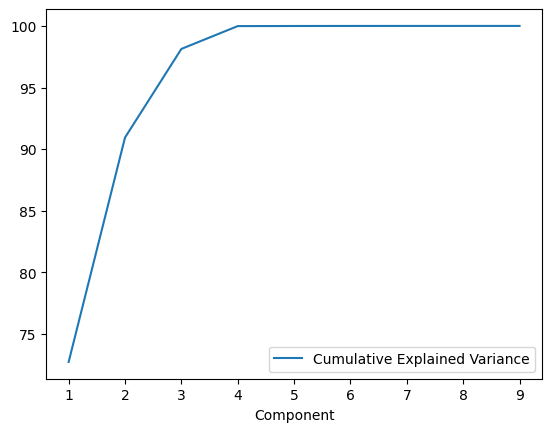

In [16]:
explained_variance_df = pd.DataFrame(zip(range(1, len(pca.explained_variance_ratio_)+1), np.array(pca.explained_variance_ratio_*100).cumsum()),
            columns=["Component", "Cumulative Explained Variance"])

explained_variance_df.plot.line(x = "Component", y= "Cumulative Explained Variance")
explained_variance_df

* About 98% of the variance is explained by first 3 components. 
* Retrain the model with 3 components only (technically reducing the dimensions from 8 to 3, without losing much signal)

In [18]:
pca = PCA(n_components=3,copy=True,random_state=42)
pca.fit(df)

# Transform the data using the fitted PCA
reduced_df = pca.transform(df)
reduced_df = pd.DataFrame(reduced_df, columns=["Dim_1", "Dim_2", "Dim_3"])
reduced_df.head()

,Dim_1,Dim_2,Dim_3
0,51.201352,-111.636978,-13.894644
1,-9.995241,-107.260369,-9.890041
2,11.336828,-113.399198,-11.218017
3,98.345569,-109.867319,-13.211879
4,104.433707,-109.687441,-11.711898


In [19]:
# Add remaining columns from all activity
reduced_df['MEMBERSHIPTYPE'] = list(all_activity_df['MEMBERSHIPTYPE'])
reduced_df['id'] = list(all_activity_df['id'])

### Plot the data with reduced dimensions (using the first 2 components)

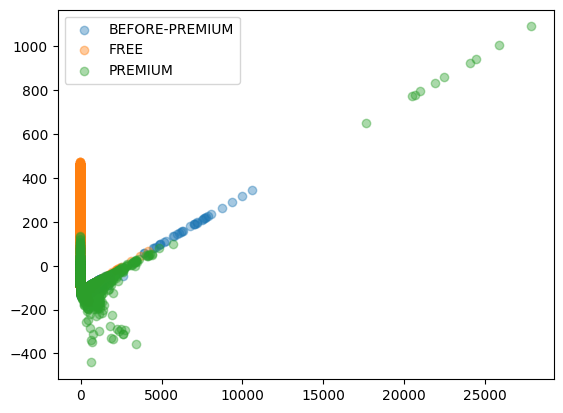

In [25]:
colors = {'BEFORE-PREMIUM':'blue', 'FREE':'red', 'PREMIUM':'green'}
fig,ax = plt.subplots()
for k,d in reduced_df.groupby('MEMBERSHIPTYPE'):
    ax.scatter(x=d['Dim_1'], y=d['Dim_2'], label=k, alpha=0.4)
plt.legend(loc=2)
# plt.savefig('scatter.png')
plt.show()

### Inference
* There is a clear distinction between the three groups. 
* We should use clustering algorithm to cluster the data
* After clustering we can get the following insights:
    * Since we are NOT using MEMBERSHIPTYPE in the PCA, we can analyze how many user actions belong to a PREMIUM vs BEFORE-PAID vs FREE members
    * We can check the individual customers activity, and understand why they are classified (or mis-classified) into a specific cluster.
    * Finally the clusters can be used to identify existing PAID customers who are assigned to a cluster with most of the FREE members activity. Such customers may be at the verge of canceling their membership

## Clustering the transformed data (from PCA)

In [26]:
# Scale the data
scaler = StandardScaler()
scaler.fit(reduced_df[["Dim_1", "Dim_2", "Dim_3"]])
reduced_df_scaled = scaler.transform(reduced_df[["Dim_1", "Dim_2", "Dim_3"]])

In [27]:
reduced_df_scaled = pd.DataFrame(reduced_df_scaled, columns=["Dim_1", "Dim_2", "Dim_3"])

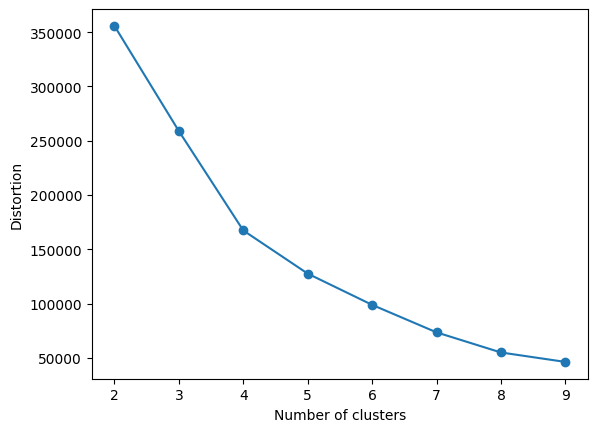

In [28]:
distortions=[]
n_clusters=range(2,10)

for i in n_clusters:
    # TODO: Apply your clustering algorithm of choice to the reduced data 
    clusterer = KMeans(n_clusters=i, init='k-means++',  n_init=10, max_iter=300, tol=1e-04, random_state=42)
    clusterer.fit(reduced_df_scaled[['Dim_1','Dim_2','Dim_3']])
    
    distortions.append(clusterer.inertia_)
    
plt.plot(n_clusters, distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

### Inference
* Choose 4 clusters as we are not seeing much gains in reducing the distortion after 4 clusters

In [30]:
# Fit a model with 4 clusters
clusterer_scaled = KMeans(n_clusters=4, init='k-means++',  n_init=10, max_iter=300, tol=1e-04, random_state=0)
clusterer_scaled.fit(reduced_df_scaled[['Dim_1', 'Dim_2', 'Dim_3']])

KMeans(n_clusters=4, random_state=0)

In [31]:
# assign other variables to the clustered df
reduced_df_scaled['cluster'] = clusterer_scaled.predict(reduced_df_scaled)
reduced_df_scaled["id"] = list(reduced_df["id"])
reduced_df_scaled["MEMBERSHIPTYPE"] = list(reduced_df["MEMBERSHIPTYPE"])
reduced_df_scaled.head()

,Dim_1,Dim_2,Dim_3,cluster,id,MEMBERSHIPTYPE
0,0.217811,-0.948826,-0.187873,0,199,BEFORE-PREMIUM
1,-0.042520,-0.911628,-0.133726,0,199,BEFORE-PREMIUM
2,0.048227,-0.963803,-0.151681,0,199,BEFORE-PREMIUM
3,0.418363,-0.933785,-0.178641,0,199,BEFORE-PREMIUM
4,0.444262,-0.932256,-0.158359,0,199,BEFORE-PREMIUM


### What is the average for the input variable `ACTIONS_CRM_CONTACTS` among 4 clusters?

In [33]:
all_activity_df['cluster'] = list(reduced_df_scaled['cluster'])

In [35]:
all_activity_df.head()

,id,ALEXA_RANK,EMPLOYEE_RANGE,INDUSTRY,MRR,DATE,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL,USERS_CRM_CONTACTS,USERS_CRM_COMPANIES,USERS_CRM_DEALS,USERS_EMAIL,LASTUSED,MEMBERSHIPTYPE,cluster
0,199,309343.0,201 to 1000,Other,290.0,2019-01-07,61.0,0.0,0.0,7.0,10.0,0.0,0.0,4.0,0,BEFORE-PREMIUM,0
1,199,309343.0,201 to 1000,Other,290.0,2019-01-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,BEFORE-PREMIUM,0
2,199,309343.0,201 to 1000,Other,290.0,2019-01-21,21.0,0.0,0.0,33.0,6.0,0.0,0.0,6.0,0,BEFORE-PREMIUM,0
3,199,309343.0,201 to 1000,Other,290.0,2019-01-28,108.0,0.0,3.0,74.0,9.0,0.0,1.0,10.0,0,BEFORE-PREMIUM,0
4,199,309343.0,201 to 1000,Other,290.0,2019-02-04,114.0,0.0,5.0,58.0,10.0,0.0,2.0,9.0,0,BEFORE-PREMIUM,0


In [36]:
all_activity_df.groupby(["cluster"]).agg({"ACTIONS_CRM_CONTACTS":"mean"})

,ACTIONS_CRM_CONTACTS
cluster,
0,16.567963
1,0.000000
2,22719.000000
3,925.014286


### Inference
* We can see that two clusters contain drastically large value.
* while one cluster contains 0 average and the other contains 16
* Clearly there are outliers in two clusters. 

### Analyzing cluster 0

In [32]:
reduced_df_scaled[reduced_df_scaled["cluster"]==0]["MEMBERSHIPTYPE"].value_counts()

FREE              100437
PREMIUM             7746
BEFORE-PREMIUM      3886
Name: MEMBERSHIPTYPE, dtype: int64

In [52]:
all_activity_df["cluster"] = list(reduced_df_scaled["cluster"])

### Inference
* This cluster contains most of the activity related to average users. 
* If a FREE Tier user's current activity belongs to this, cluster, then there is a 7% chance that they can become a PAID customer.


In [39]:
print(len(set(reduced_df_scaled[reduced_df_scaled["cluster"]==0]["id"])))
print(list(set(reduced_df_scaled[reduced_df_scaled["cluster"]==0]["id"]))[0:10])

3569
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


### Plot user activity based on `ACTIONS_CRM_CONTACTS` for some of the customers in GROUP-0

<AxesSubplot: xlabel='DATE'>

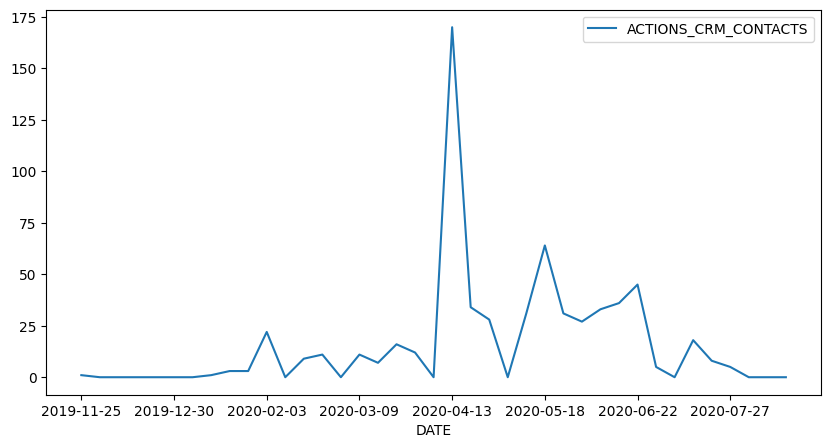

In [40]:
all_activity_df[all_activity_df["id"] == 9].plot.line(x="DATE", y="ACTIONS_CRM_CONTACTS", figsize=(10,5))

<AxesSubplot: xlabel='DATE'>

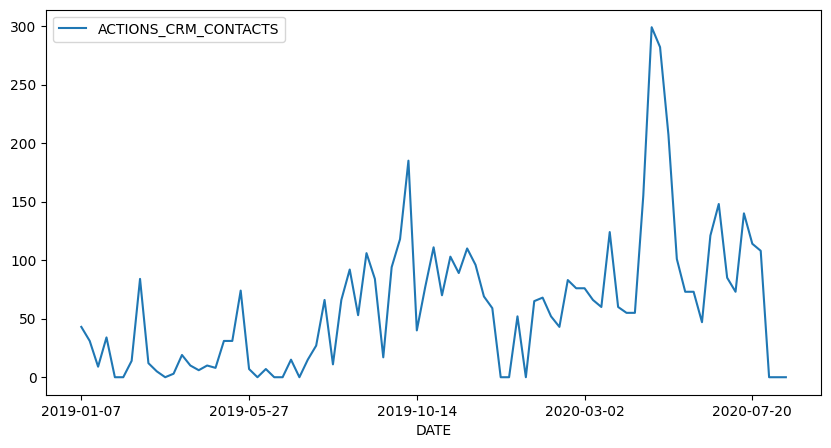

In [41]:
all_activity_df[all_activity_df["id"] == 5].plot.line(x="DATE", y="ACTIONS_CRM_CONTACTS", figsize=(10,5))

In [54]:
all_activity_df[all_activity_df["cluster"] == 0]["ACTIONS_CRM_CONTACTS"].std()

168.8784618985373

In [55]:
all_activity_df[all_activity_df["cluster"] == 0]["ACTIONS_CRM_CONTACTS"].mean()

16.567962594473048

* This group's customer activity is the most normal activity. 
* They are still using the system.
* Based on their current activity, FREE members have a 7% chance to become PAID member

### Analyzing cluster 1

In [44]:
reduced_df_scaled[reduced_df_scaled["cluster"]==1]["MEMBERSHIPTYPE"].value_counts()

FREE              42957
PREMIUM              41
BEFORE-PREMIUM       11
Name: MEMBERSHIPTYPE, dtype: int64

### Inference
* This cluster contains most of the activity related to DORMANT users. 
* If a FREE Tier user's current activity belongs to this, cluster, just ignore them from marketing.
* If a paid customer belongs to this cluster, then they are at the verge of canceling their membership.


In [45]:
print(len(set(reduced_df_scaled[reduced_df_scaled["cluster"]==1]["id"])))
print(list(set(reduced_df_scaled[reduced_df_scaled["cluster"]==1]["id"]))[0:10])

2035
[10, 47, 77, 80, 87, 95, 144, 173, 179, 206]


### Plot user activity based on `ACTIONS_CRM_CONTACTS` for some of the customers in GROUP-1

In [47]:
set(reduced_df_scaled[(reduced_df_scaled["cluster"]==1) & (reduced_df_scaled["MEMBERSHIPTYPE"]=='PREMIUM')]["id"])

{10, 77, 80, 87, 144, 179}

* We obtained 6 customers as the PREMIUM Ids

<AxesSubplot: xlabel='DATE'>

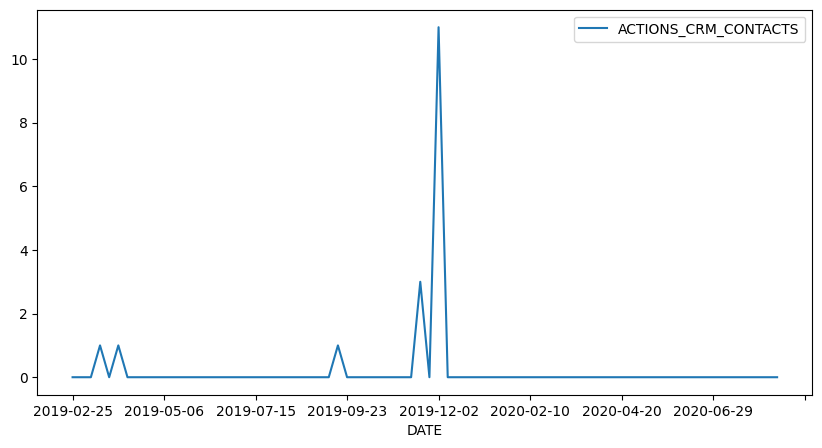

In [49]:
# Check the activity related to 144 customer
all_activity_df[all_activity_df["id"] == 144].plot.line(x="DATE", y="ACTIONS_CRM_CONTACTS", figsize=(10,5))

<AxesSubplot: xlabel='DATE'>

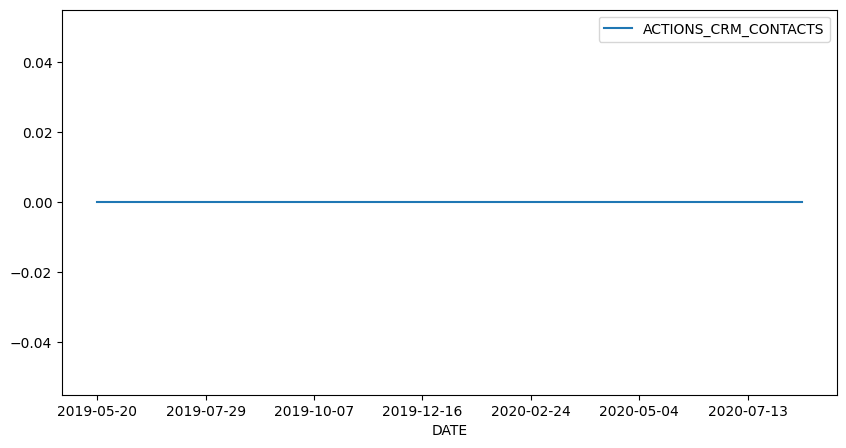

In [50]:
# Check the activity related to 206 customer
all_activity_df[all_activity_df["id"] == 206].plot.line(x="DATE", y="ACTIONS_CRM_CONTACTS", figsize=(10,5))

<AxesSubplot: xlabel='DATE'>

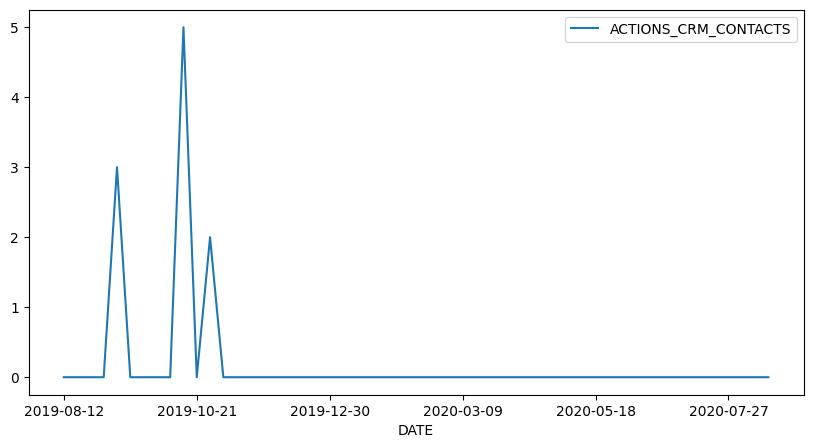

In [56]:
# Check the activity related to 10 customer
all_activity_df[all_activity_df["id"] == 10].plot.line(x="DATE", y="ACTIONS_CRM_CONTACTS", figsize=(10,5))

### Inference
* Clearly, these customers (PAID Members) are NOT using the system well, and they might cancel the membership soon

In [57]:
all_activity_df[all_activity_df["cluster"] == 1]["ACTIONS_CRM_CONTACTS"].mean()

0.0

In [58]:
all_activity_df[all_activity_df["cluster"] == 1]["ACTIONS_CRM_CONTACTS"].std()

0.0

* If the current user's activity falls into this cluster, then that user is not using the system. They are dormant.

### Analyzing cluster 2

In [59]:
reduced_df_scaled[reduced_df_scaled["cluster"]==2]["MEMBERSHIPTYPE"].value_counts()

PREMIUM    10
Name: MEMBERSHIPTYPE, dtype: int64

In [60]:
print(len(set(reduced_df_scaled[reduced_df_scaled["cluster"]==2]["id"])))
print(list(set(reduced_df_scaled[reduced_df_scaled["cluster"]==2]["id"]))[0:10])

1
[119]


### Inference
* We have only one customer in this cluster. Let us check how their activity looks

### Plot user activity based on `ACTIONS_CRM_CONTACTS` for some of the customers in GROUP-2

In [61]:
set(reduced_df_scaled[(reduced_df_scaled["cluster"]==2) & (reduced_df_scaled["MEMBERSHIPTYPE"]=='PREMIUM')]["id"])

{119}

* It is a PREMIUM Customer ID

<AxesSubplot: xlabel='DATE'>

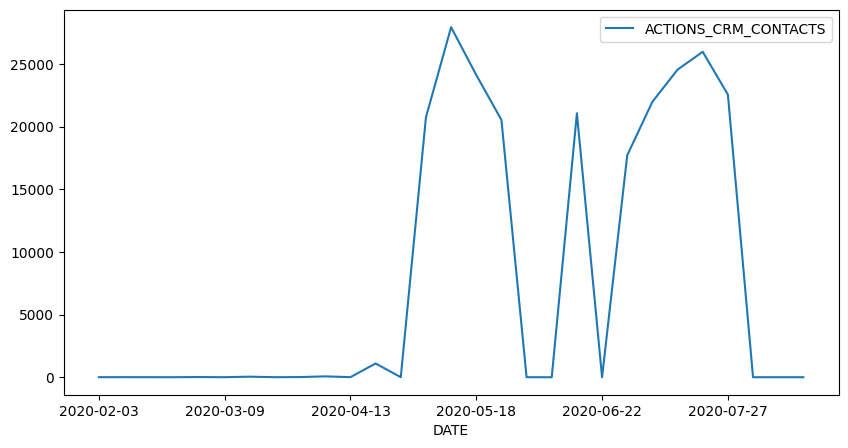

In [62]:
# Check the activity related to 144 customer
all_activity_df[all_activity_df["id"] == 119].plot.line(x="DATE", y="ACTIONS_CRM_CONTACTS", figsize=(10,5))

### Inference
* Clearly we have a lot of abnormal activity. 
* Is the data correct for this customer?

### Analyzing cluster 3

In [63]:
reduced_df_scaled[reduced_df_scaled["cluster"]==3]["MEMBERSHIPTYPE"].value_counts()

PREMIUM           68
BEFORE-PREMIUM     1
FREE               1
Name: MEMBERSHIPTYPE, dtype: int64

In [64]:
print(len(set(reduced_df_scaled[reduced_df_scaled["cluster"]==3]["id"])))
print(list(set(reduced_df_scaled[reduced_df_scaled["cluster"]==3]["id"]))[0:10])

4
[65, 50, 4691, 148]


### Plot user activity based on `ACTIONS_CRM_CONTACTS` for some of the customers in GROUP-2

In [65]:
set(reduced_df_scaled[(reduced_df_scaled["cluster"]==3) & (reduced_df_scaled["MEMBERSHIPTYPE"]=='PREMIUM')]["id"])

{50, 65, 148}

* It is a PREMIUM Customer ID

<AxesSubplot: xlabel='DATE'>

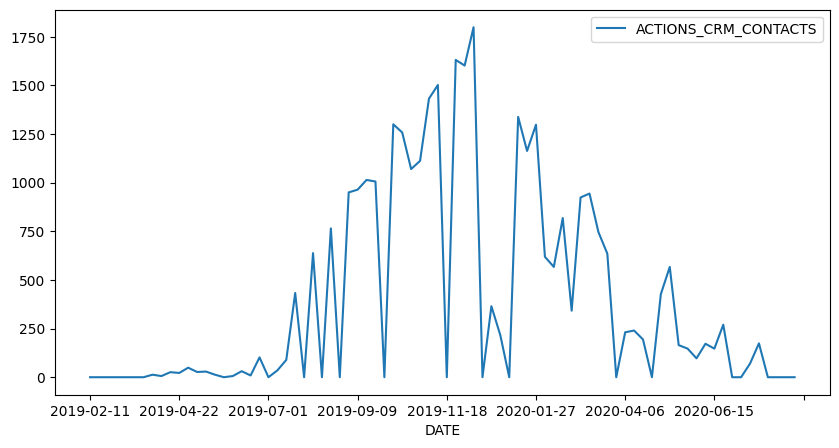

In [66]:
# Check the activity related to 144 customer
all_activity_df[all_activity_df["id"] == 50].plot.line(x="DATE", y="ACTIONS_CRM_CONTACTS", figsize=(10,5))

<AxesSubplot: xlabel='DATE'>

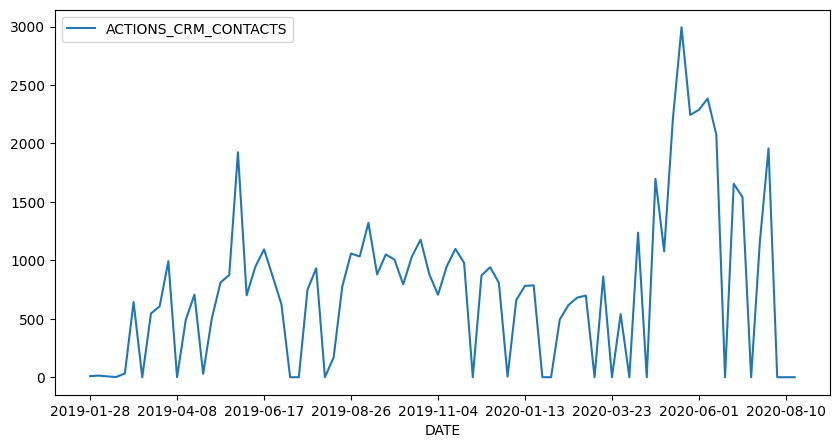

In [67]:
# Check the activity related to 144 customer
all_activity_df[all_activity_df["id"] == 148].plot.line(x="DATE", y="ACTIONS_CRM_CONTACTS", figsize=(10,5))

<AxesSubplot: title={'center': 'CRM Contact Actions for customer 65'}, xlabel='DATE'>

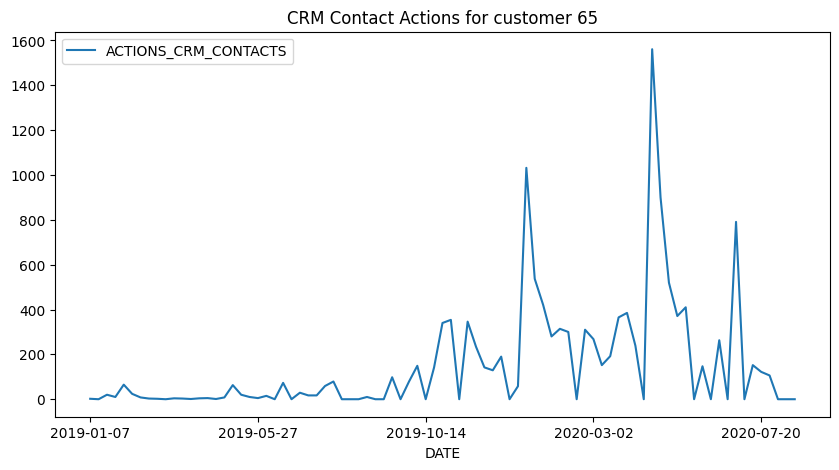

In [331]:
# Check the activity related to 144 customer
all_activity_df[all_activity_df["id"] == 65].plot.line(x="DATE", y="ACTIONS_CRM_CONTACTS", figsize=(10,5), 
                                                      title = "CRM Contact Actions for customer 65")

<AxesSubplot: title={'center': 'CRM Contact Actions for customer 4691'}, xlabel='DATE'>

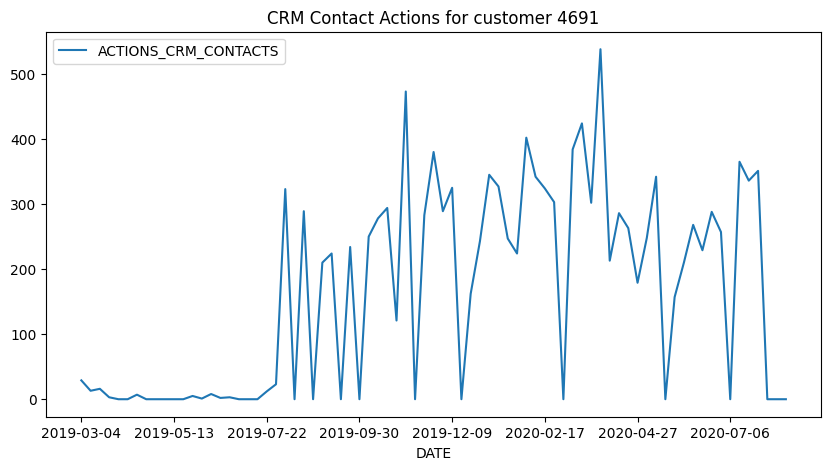

In [333]:
all_activity_df[all_activity_df["id"] == 4691].plot.line(x="DATE", y="ACTIONS_CRM_CONTACTS", figsize=(10,5), 
                                                      title = "CRM Contact Actions for customer 4691")

<AxesSubplot: title={'center': 'CRM Contact Actions for customer 5'}, xlabel='DATE'>

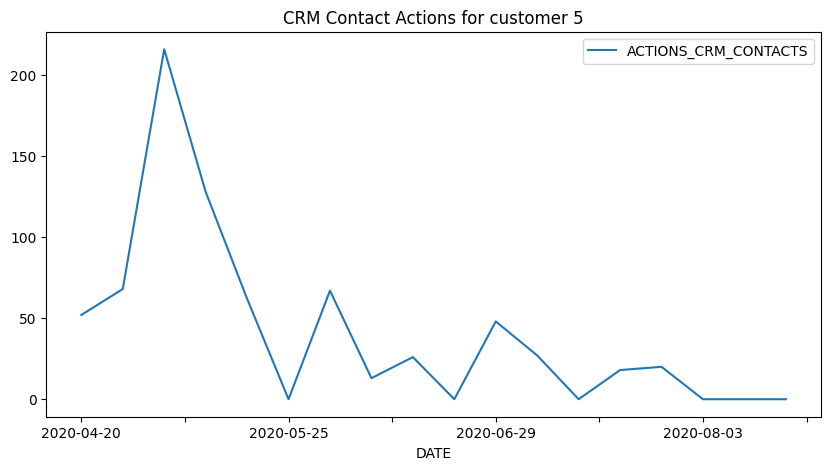

In [335]:
all_activity_df[all_activity_df["id"] == 8].plot.line(x="DATE", y="ACTIONS_CRM_CONTACTS", figsize=(10,5), 
                                                      title = "CRM Contact Actions for customer 5")

<AxesSubplot: title={'center': 'CRM Contact Actions for customer 300'}, xlabel='DATE'>

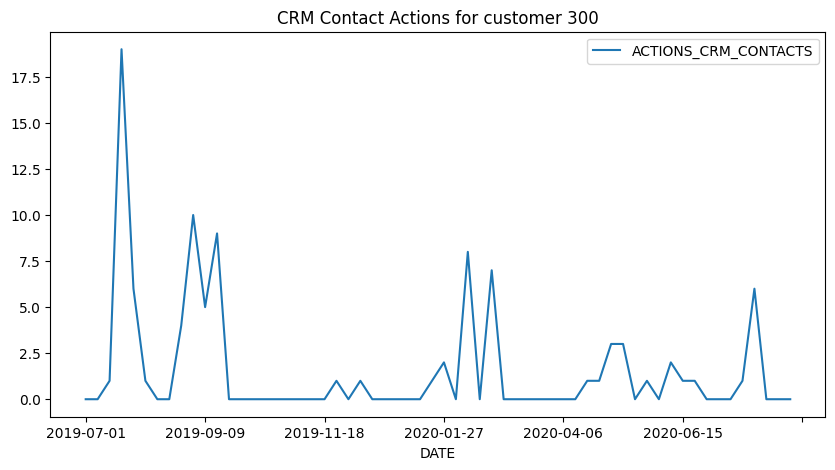

In [337]:
all_activity_df[all_activity_df["id"] == 300].plot.line(x="DATE", y="ACTIONS_CRM_CONTACTS", figsize=(10,5), 
                                                      title = "CRM Contact Actions for customer 300")

<AxesSubplot: title={'center': 'CRM Contact Actions for customer 196'}, xlabel='DATE'>

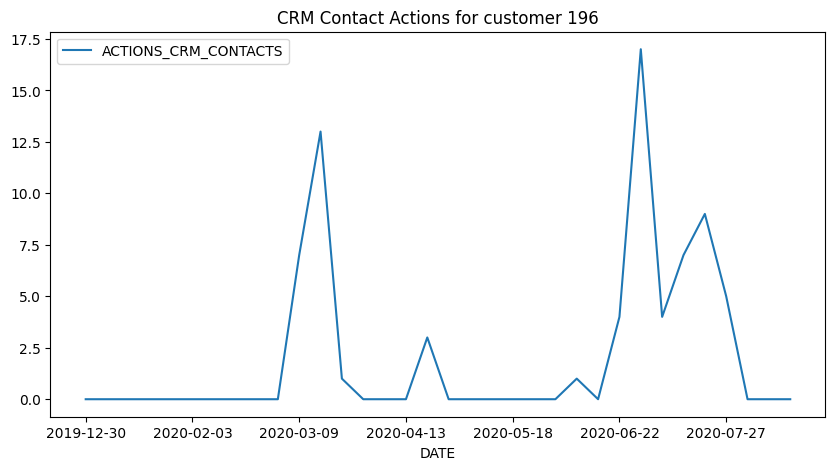

In [359]:
all_activity_df[all_activity_df["id"] == 196].plot.line(x="DATE", y="ACTIONS_CRM_CONTACTS", figsize=(10,5), 
                                                      title = "CRM Contact Actions for customer 196")

<AxesSubplot: title={'center': 'CRM Contact Actions for customer 82'}, xlabel='DATE'>

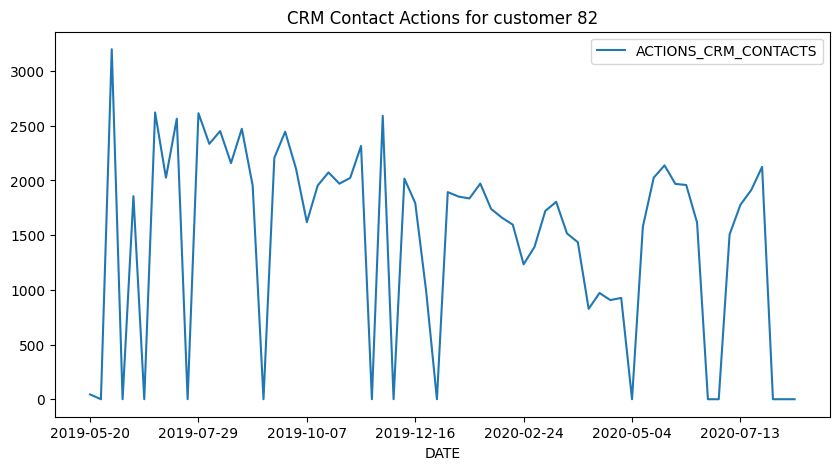

In [361]:
all_activity_df[all_activity_df["id"] == 82].plot.line(x="DATE", y="ACTIONS_CRM_CONTACTS", figsize=(10,5), 
                                                      title = "CRM Contact Actions for customer 82")

<AxesSubplot: title={'center': 'CRM Contact Actions for customer 5144'}, xlabel='DATE'>

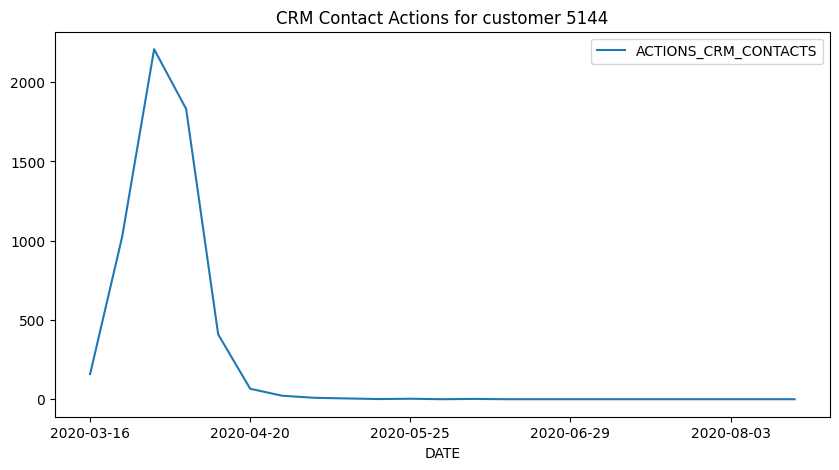

In [362]:
all_activity_df[all_activity_df["id"] == 5144].plot.line(x="DATE", y="ACTIONS_CRM_CONTACTS", figsize=(10,5), 
                                                      title = "CRM Contact Actions for customer 5144")

<AxesSubplot: title={'center': 'CRM Contact Actions for customer 92'}, xlabel='DATE'>

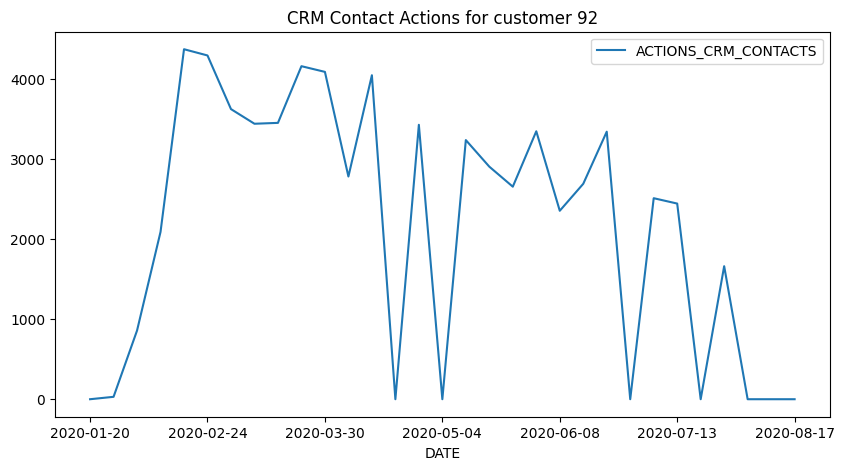

In [365]:
all_activity_df[all_activity_df["id"] == 92].plot.line(x="DATE", y="ACTIONS_CRM_CONTACTS", figsize=(10,5), 
                                                      title = "CRM Contact Actions for customer 92")

### Inference
* Clearly we have a lot of abnormal activity for these customers also. 
* Therefore it is better to ignore the customers from further consideration

## NOTE: 
Given that 119 customer contains abnormal data, it is better to drop them and re-run the clustering. But let us ignore as we do not have much time. We will do this when we present the results to the business.

In [74]:
all_activity_df.drop(all_activity_df[all_activity_df["id"].isin([119, 50])].index, inplace=True)

In [75]:
all_activity_df.head()

,id,ALEXA_RANK,EMPLOYEE_RANGE,INDUSTRY,MRR,DATE,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL,USERS_CRM_CONTACTS,USERS_CRM_COMPANIES,USERS_CRM_DEALS,USERS_EMAIL,LASTUSED,MEMBERSHIPTYPE,cluster
0,199,309343.0,201 to 1000,Other,290.0,2019-01-07,61.0,0.0,0.0,7.0,10.0,0.0,0.0,4.0,0,BEFORE-PREMIUM,0
1,199,309343.0,201 to 1000,Other,290.0,2019-01-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,BEFORE-PREMIUM,0
2,199,309343.0,201 to 1000,Other,290.0,2019-01-21,21.0,0.0,0.0,33.0,6.0,0.0,0.0,6.0,0,BEFORE-PREMIUM,0
3,199,309343.0,201 to 1000,Other,290.0,2019-01-28,108.0,0.0,3.0,74.0,9.0,0.0,1.0,10.0,0,BEFORE-PREMIUM,0
4,199,309343.0,201 to 1000,Other,290.0,2019-02-04,114.0,0.0,5.0,58.0,10.0,0.0,2.0,9.0,0,BEFORE-PREMIUM,0


## Phase 2
MRR Predictor

In [91]:
common_cluster = [1]
uncommon_clusters = [2, 3]
normal_ids = set(all_activity_df[all_activity_df["cluster"].isin(common_cluster)]["id"]) - \
set(all_activity_df[all_activity_df["cluster"].isin(uncommon_clusters)]["id"])
training_df = all_activity_df[all_activity_df["id"].isin(normal_ids)]
training_df = training_df[training_df["MEMBERSHIPTYPE"] == 'PREMIUM']
training_df.head()

,id,ALEXA_RANK,EMPLOYEE_RANGE,INDUSTRY,MRR,DATE,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL,USERS_CRM_CONTACTS,USERS_CRM_COMPANIES,USERS_CRM_DEALS,USERS_EMAIL,LASTUSED,MEMBERSHIPTYPE,cluster
5149,47,7439329.0,6 to 10,NaN,50.0,2020-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,PREMIUM,0
5150,47,7439329.0,6 to 10,NaN,50.0,2020-06-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,PREMIUM,0
5151,47,7439329.0,6 to 10,NaN,50.0,2020-06-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,PREMIUM,0
5152,47,7439329.0,6 to 10,NaN,50.0,2020-06-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,PREMIUM,0
5153,47,7439329.0,6 to 10,NaN,50.0,2020-06-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,PREMIUM,0


In [93]:
training_df.shape

(433, 17)

<AxesSubplot: ylabel='Frequency'>

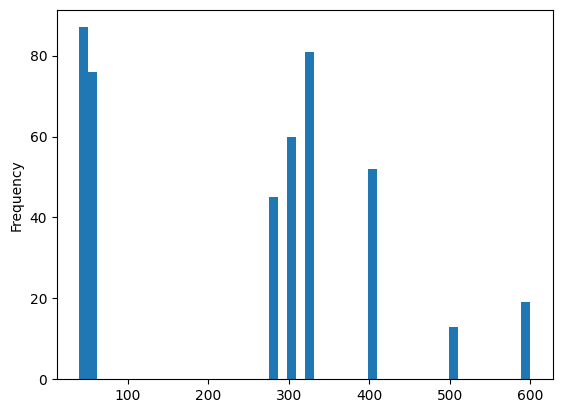

In [96]:
training_df['MRR'].plot.hist(bins=50)

In [97]:
training_df['MRR'].value_counts()

320.00    81
51.43     76
40.00     75
300.00    60
400.00    52
280.00    45
600.00    19
500.00    13
50.00     12
Name: MRR, dtype: int64

In [98]:
set(training_df["id"])

{10, 47, 77, 80, 87, 95, 144, 173, 179}

In [100]:
training_df = all_activity_df[(all_activity_df["cluster"]==1) & 
                              (all_activity_df["MEMBERSHIPTYPE"] =='BEFORE-PREMIUM')]

In [101]:
set(training_df["id"])

{47, 95, 173}

In [104]:
set(all_activity_df[all_activity_df["cluster"]==1]["id"])

{10,
 47,
 77,
 80,
 87,
 95,
 144,
 173,
 179,
 206,
 207,
 211,
 215,
 217,
 218,
 221,
 223,
 224,
 225,
 227,
 262,
 264,
 266,
 275,
 277,
 278,
 284,
 286,
 287,
 288,
 289,
 291,
 293,
 294,
 296,
 299,
 302,
 305,
 307,
 310,
 311,
 315,
 318,
 320,
 321,
 322,
 324,
 325,
 326,
 327,
 332,
 334,
 335,
 337,
 338,
 340,
 341,
 342,
 343,
 347,
 352,
 354,
 355,
 356,
 357,
 358,
 360,
 364,
 368,
 369,
 371,
 373,
 375,
 378,
 380,
 381,
 387,
 390,
 397,
 398,
 400,
 401,
 404,
 405,
 407,
 411,
 413,
 414,
 415,
 421,
 422,
 424,
 425,
 426,
 429,
 430,
 431,
 433,
 438,
 439,
 440,
 449,
 450,
 454,
 455,
 463,
 464,
 466,
 468,
 473,
 474,
 475,
 478,
 483,
 484,
 487,
 489,
 490,
 492,
 493,
 497,
 501,
 503,
 508,
 510,
 511,
 517,
 518,
 523,
 524,
 529,
 531,
 533,
 536,
 541,
 550,
 552,
 554,
 556,
 559,
 561,
 567,
 572,
 576,
 581,
 582,
 584,
 586,
 587,
 591,
 592,
 594,
 595,
 600,
 602,
 606,
 608,
 609,
 615,
 617,
 620,
 625,
 626,
 627,
 629,
 631,
 632,
 635

In [106]:
all_activity_df[(all_activity_df["cluster"]==1) & (all_activity_df["MEMBERSHIPTYPE"]=='PREMIUM')]

,id,ALEXA_RANK,EMPLOYEE_RANGE,INDUSTRY,MRR,DATE,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL,USERS_CRM_CONTACTS,USERS_CRM_COMPANIES,USERS_CRM_DEALS,USERS_EMAIL,LASTUSED,MEMBERSHIPTYPE,cluster
5492,179,34064.0,6 to 10,ACCOUNTING,320.00,2020-06-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,168,PREMIUM,1
5493,179,34064.0,6 to 10,ACCOUNTING,320.00,2020-06-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,175,PREMIUM,1
5494,179,34064.0,6 to 10,ACCOUNTING,320.00,2020-07-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,182,PREMIUM,1
5495,179,34064.0,6 to 10,ACCOUNTING,320.00,2020-07-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,189,PREMIUM,1
5496,179,34064.0,6 to 10,ACCOUNTING,320.00,2020-07-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,196,PREMIUM,1
5497,179,34064.0,6 to 10,ACCOUNTING,320.00,2020-07-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203,PREMIUM,1
5498,179,34064.0,6 to 10,ACCOUNTING,320.00,2020-08-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,210,PREMIUM,1
5499,179,34064.0,6 to 10,ACCOUNTING,320.00,2020-08-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,217,PREMIUM,1
5500,179,34064.0,6 to 10,ACCOUNTING,320.00,2020-08-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,224,PREMIUM,1
6479,144,2754845.0,6 to 10,NaN,40.00,2020-07-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,168,PREMIUM,1


In [108]:
all_activity_df[(all_activity_df["MRR"]>0)]

,id,ALEXA_RANK,EMPLOYEE_RANGE,INDUSTRY,MRR,DATE,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL,USERS_CRM_CONTACTS,USERS_CRM_COMPANIES,USERS_CRM_DEALS,USERS_EMAIL,LASTUSED,MEMBERSHIPTYPE,cluster
0,199,309343.0,201 to 1000,Other,290.00,2019-01-07,61.0,0.0,0.0,7.0,10.0,0.0,0.0,4.0,0,BEFORE-PREMIUM,0
1,199,309343.0,201 to 1000,Other,290.00,2019-01-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,BEFORE-PREMIUM,0
2,199,309343.0,201 to 1000,Other,290.00,2019-01-21,21.0,0.0,0.0,33.0,6.0,0.0,0.0,6.0,0,BEFORE-PREMIUM,0
3,199,309343.0,201 to 1000,Other,290.00,2019-01-28,108.0,0.0,3.0,74.0,9.0,0.0,1.0,10.0,0,BEFORE-PREMIUM,0
4,199,309343.0,201 to 1000,Other,290.00,2019-02-04,114.0,0.0,5.0,58.0,10.0,0.0,2.0,9.0,0,BEFORE-PREMIUM,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11758,14,16000001.0,11 to 25,NaN,321.35,2020-08-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21,PREMIUM,0
11759,160,16000001.0,6 to 10,NaN,68.57,2020-07-27,3.0,1.0,2.0,0.0,1.0,1.0,1.0,0.0,0,BEFORE-PREMIUM,0
11760,160,16000001.0,6 to 10,NaN,68.57,2020-08-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,BEFORE-PREMIUM,0
11761,160,16000001.0,6 to 10,NaN,68.57,2020-08-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,BEFORE-PREMIUM,0


<AxesSubplot: ylabel='Frequency'>

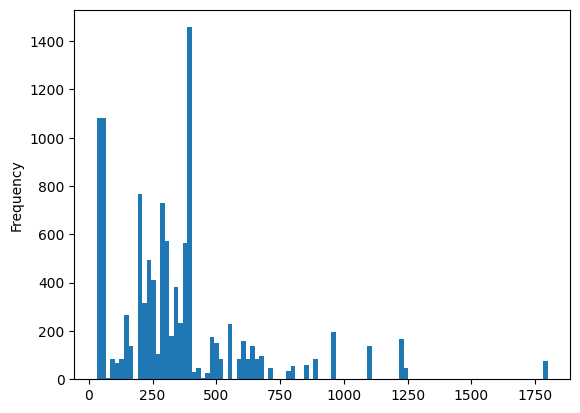

In [111]:
all_activity_df[(all_activity_df["MRR"]>0)]['MRR'].plot.hist(bins=100)

In [114]:
all_activity_df[(all_activity_df["MRR"]>0)]['MRR'].value_counts().sort_index()

32.00       52
39.26      229
40.00      462
49.06       91
49.07      249
          ... 
1104.00    139
1217.06     85
1231.95     82
1251.20     46
1800.00     76
Name: MRR, Length: 93, dtype: int64

In [115]:
all_activity_df["MEMBERSHIPTYPE"].value_counts() 

FREE              143286
PREMIUM             7768
BEFORE-PREMIUM      3886
Name: MEMBERSHIPTYPE, dtype: int64

In [118]:
set(all_activity_df[(all_activity_df["MEMBERSHIPTYPE"] == 'BEFORE-PREMIUM') & 
                    (all_activity_df["MRR"] > 0)  
                   ]["id"])

{1,
 2,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 12,
 13,
 14,
 15,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 30,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 67,
 68,
 70,
 71,
 73,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 85,
 86,
 88,
 89,
 90,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 109,
 110,
 111,
 113,
 114,
 115,
 116,
 117,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 198,
 199,
 200}

In [251]:
df = all_activity_df[(all_activity_df["MEMBERSHIPTYPE"] == 'BEFORE-PREMIUM') & 
                    (all_activity_df["MRR"] > 0)  
                   ]

In [252]:
df

,id,ALEXA_RANK,EMPLOYEE_RANGE,INDUSTRY,MRR,DATE,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL,USERS_CRM_CONTACTS,USERS_CRM_COMPANIES,USERS_CRM_DEALS,USERS_EMAIL,LASTUSED,MEMBERSHIPTYPE,cluster
0,199,309343.0,201 to 1000,Other,290.00,2019-01-07,61.0,0.0,0.0,7.0,10.0,0.0,0.0,4.0,0,BEFORE-PREMIUM,0
1,199,309343.0,201 to 1000,Other,290.00,2019-01-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,BEFORE-PREMIUM,0
2,199,309343.0,201 to 1000,Other,290.00,2019-01-21,21.0,0.0,0.0,33.0,6.0,0.0,0.0,6.0,0,BEFORE-PREMIUM,0
3,199,309343.0,201 to 1000,Other,290.00,2019-01-28,108.0,0.0,3.0,74.0,9.0,0.0,1.0,10.0,0,BEFORE-PREMIUM,0
4,199,309343.0,201 to 1000,Other,290.00,2019-02-04,114.0,0.0,5.0,58.0,10.0,0.0,2.0,9.0,0,BEFORE-PREMIUM,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11752,14,16000001.0,11 to 25,NaN,321.35,2020-07-06,19.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,BEFORE-PREMIUM,0
11759,160,16000001.0,6 to 10,NaN,68.57,2020-07-27,3.0,1.0,2.0,0.0,1.0,1.0,1.0,0.0,0,BEFORE-PREMIUM,0
11760,160,16000001.0,6 to 10,NaN,68.57,2020-08-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,BEFORE-PREMIUM,0
11761,160,16000001.0,6 to 10,NaN,68.57,2020-08-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,BEFORE-PREMIUM,0


<AxesSubplot: ylabel='Frequency'>

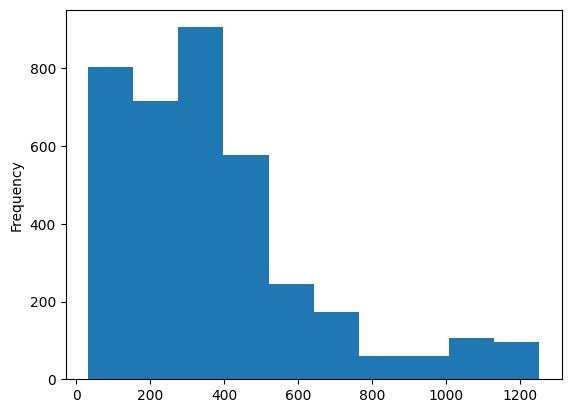

In [253]:
df['MRR'].plot.hist()

In [254]:
import random
random.sample([1,2,3,4], 3)

[1, 3, 4]

In [255]:
# Randomly select some IDs and keep them aside

len(list(set(df["id"])))

179

In [256]:
# Randomly select some IDs and keep them aside
random.seed(42)
test_ids = random.sample((list(set(df["id"]))), 20)

In [257]:
test_df = all_activity_df[all_activity_df["id"].isin(test_ids)]

In [258]:
test_df.head()

,id,ALEXA_RANK,EMPLOYEE_RANGE,INDUSTRY,MRR,DATE,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL,USERS_CRM_CONTACTS,USERS_CRM_COMPANIES,USERS_CRM_DEALS,USERS_EMAIL,LASTUSED,MEMBERSHIPTYPE,cluster
679,32,1256632.0,6 to 10,Technology - Software,375.0,2019-01-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,BEFORE-PREMIUM,0
680,32,1256632.0,6 to 10,Technology - Software,375.0,2019-01-14,7.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0,BEFORE-PREMIUM,0
681,32,1256632.0,6 to 10,Technology - Software,375.0,2019-01-21,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,BEFORE-PREMIUM,0
682,32,1256632.0,6 to 10,Technology - Software,375.0,2019-01-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,BEFORE-PREMIUM,0
683,32,1256632.0,6 to 10,Technology - Software,375.0,2019-02-04,4.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0,BEFORE-PREMIUM,0


In [259]:
test_df.shape

(1023, 17)

In [260]:
train_ids = set(df["id"]) - set(test_ids)

In [261]:
print(train_ids)

{1, 2, 4, 5, 6, 7, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 28, 30, 33, 35, 36, 37, 38, 39, 41, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 67, 70, 71, 75, 76, 77, 78, 79, 80, 81, 83, 85, 86, 88, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 113, 114, 115, 116, 117, 120, 121, 122, 123, 124, 125, 126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 142, 143, 144, 145, 146, 147, 148, 151, 152, 153, 154, 155, 156, 157, 158, 159, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 173, 174, 176, 177, 178, 179, 180, 181, 182, 183, 185, 186, 187, 188, 189, 190, 191, 192, 193, 195, 196, 198, 199, 200}


In [262]:
train_df = all_activity_df[all_activity_df["id"].isin(train_ids)]

In [263]:
train_df.shape

(9687, 17)

In [264]:
train_df.head()

,id,ALEXA_RANK,EMPLOYEE_RANGE,INDUSTRY,MRR,DATE,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL,USERS_CRM_CONTACTS,USERS_CRM_COMPANIES,USERS_CRM_DEALS,USERS_EMAIL,LASTUSED,MEMBERSHIPTYPE,cluster
0,199,309343.0,201 to 1000,Other,290.0,2019-01-07,61.0,0.0,0.0,7.0,10.0,0.0,0.0,4.0,0,BEFORE-PREMIUM,0
1,199,309343.0,201 to 1000,Other,290.0,2019-01-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,BEFORE-PREMIUM,0
2,199,309343.0,201 to 1000,Other,290.0,2019-01-21,21.0,0.0,0.0,33.0,6.0,0.0,0.0,6.0,0,BEFORE-PREMIUM,0
3,199,309343.0,201 to 1000,Other,290.0,2019-01-28,108.0,0.0,3.0,74.0,9.0,0.0,1.0,10.0,0,BEFORE-PREMIUM,0
4,199,309343.0,201 to 1000,Other,290.0,2019-02-04,114.0,0.0,5.0,58.0,10.0,0.0,2.0,9.0,0,BEFORE-PREMIUM,0


In [304]:
from sklearn.base import BaseEstimator, TransformerMixin

class NumericColumnTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['ACTIONS_CRM_CONTACTS_RATIO'] = X['ACTIONS_CRM_CONTACTS']/(X['USERS_CRM_CONTACTS'] + 1)
        X['ACTIONS_CRM_COMPANIES_RATIO'] = X['ACTIONS_CRM_COMPANIES']/(X['USERS_CRM_COMPANIES'] + 1)
        X['ACTIONS_CRM_DEALS_RATIO'] = X['ACTIONS_CRM_DEALS']/(X['USERS_CRM_DEALS'] + 1)
        X['ACTIONS_EMAIL_RATIO'] = X['ACTIONS_EMAIL']/(X['USERS_EMAIL'] + 1)
        X = X[['id','ACTIONS_CRM_CONTACTS_RATIO', 'ACTIONS_CRM_COMPANIES_RATIO', 'ACTIONS_CRM_DEALS_RATIO', 'ACTIONS_EMAIL_RATIO', 'MRR']]
        X.drop_duplicates(inplace=True)
        return X[['id','ACTIONS_CRM_CONTACTS_RATIO', 'ACTIONS_CRM_COMPANIES_RATIO', 'ACTIONS_CRM_DEALS_RATIO', 'ACTIONS_EMAIL_RATIO', 'MRR']]

In [305]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('col_transformer', NumericColumnTransformer()),
    ('imputer', SimpleImputer(strategy="median")),
   ('std-scaler', StandardScaler())
])

In [306]:
train_df.head()

,id,ALEXA_RANK,EMPLOYEE_RANGE,INDUSTRY,MRR,DATE,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL,...,USERS_CRM_COMPANIES,USERS_CRM_DEALS,USERS_EMAIL,LASTUSED,MEMBERSHIPTYPE,cluster,ACTIONS_CRM_CONTACTS_RATIO,ACTIONS_CRM_COMPANIES_RATIO,ACTIONS_CRM_DEALS_RATIO,ACTIONS_EMAIL_RATIO
0,199,309343.0,201 to 1000,Other,290.0,2019-01-07,61.0,0.0,0.0,7.0,...,0.0,0.0,4.0,0,BEFORE-PREMIUM,0,5.545455,0.0,0.000000,1.400000
1,199,309343.0,201 to 1000,Other,290.0,2019-01-14,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,7,BEFORE-PREMIUM,0,0.000000,0.0,0.000000,0.000000
2,199,309343.0,201 to 1000,Other,290.0,2019-01-21,21.0,0.0,0.0,33.0,...,0.0,0.0,6.0,0,BEFORE-PREMIUM,0,3.000000,0.0,0.000000,4.714286
3,199,309343.0,201 to 1000,Other,290.0,2019-01-28,108.0,0.0,3.0,74.0,...,0.0,1.0,10.0,0,BEFORE-PREMIUM,0,10.800000,0.0,1.500000,6.727273
4,199,309343.0,201 to 1000,Other,290.0,2019-02-04,114.0,0.0,5.0,58.0,...,0.0,2.0,9.0,0,BEFORE-PREMIUM,0,10.363636,0.0,1.666667,5.800000


In [307]:
pd.options.mode.chained_assignment = None
num_pipeline.fit(train_df)

Pipeline(steps=[('col_transformer', NumericColumnTransformer()),
                ('imputer', SimpleImputer(strategy='median')),
                ('std-scaler', StandardScaler())])

In [300]:
X_train = num_pipeline.transform(train_df)

In [301]:
y_train = train_df['MRR']

In [302]:
X_train.shape

(5913, 5)

In [303]:
y_train.shape

(9687,)

In [273]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [274]:
X_test = num_pipeline.transform(test_df)

In [275]:
y_test = test_df['MRR']

In [276]:
X_test.shape

(1023, 4)

In [277]:
y_test.shape

(1023,)

In [281]:
y_test_predictions = lin_reg.predict(X_test)

In [285]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_test_predictions)

In [286]:
np.sqrt(mse)

204.86656591708626

In [287]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor()

In [288]:
y_test_predictions = tree_reg.predict(X_test)

In [289]:
mse = mean_squared_error(y_test, y_test_predictions)

In [290]:
np.sqrt(mse)

281.40880365064095

In [293]:
(y_test_predictions).min()

39.26

In [295]:
(y_test_predictions).max()

1251.2

<AxesSubplot: xlabel='ACTIONS_CRM_CONTACTS', ylabel='MRR'>

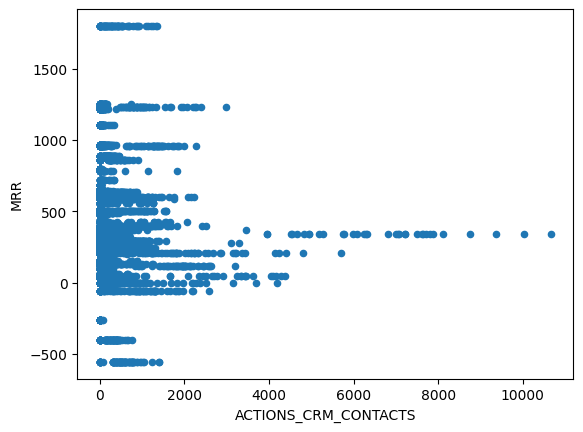

In [308]:
all_activity_df.plot.scatter(x="ACTIONS_CRM_CONTACTS", y ="MRR")

In [315]:
#10, 47, 77, 80, 87, 95, 144, 173, 179, 206
all_activity_df[all_activity_df["id"] == 10]

,id,ALEXA_RANK,EMPLOYEE_RANGE,INDUSTRY,MRR,DATE,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL,USERS_CRM_CONTACTS,USERS_CRM_COMPANIES,USERS_CRM_DEALS,USERS_EMAIL,LASTUSED,MEMBERSHIPTYPE,cluster
9643,10,302735.0,201 to 1000,Consulting/Advisory,280.0,2019-08-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,BEFORE-PREMIUM,0
9644,10,302735.0,201 to 1000,Consulting/Advisory,280.0,2019-08-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,BEFORE-PREMIUM,0
9645,10,302735.0,201 to 1000,Consulting/Advisory,280.0,2019-08-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,BEFORE-PREMIUM,0
9646,10,302735.0,201 to 1000,Consulting/Advisory,280.0,2019-09-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21,BEFORE-PREMIUM,0
9647,10,302735.0,201 to 1000,Consulting/Advisory,280.0,2019-09-09,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,BEFORE-PREMIUM,0
9648,10,302735.0,201 to 1000,Consulting/Advisory,280.0,2019-09-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,BEFORE-PREMIUM,0
9649,10,302735.0,201 to 1000,Consulting/Advisory,280.0,2019-09-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,BEFORE-PREMIUM,0
9650,10,302735.0,201 to 1000,Consulting/Advisory,280.0,2019-09-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,BEFORE-PREMIUM,0
9651,10,302735.0,201 to 1000,Consulting/Advisory,280.0,2019-10-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,BEFORE-PREMIUM,0
9652,10,302735.0,201 to 1000,Consulting/Advisory,280.0,2019-10-14,5.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0,PREMIUM,0


<AxesSubplot: title={'center': 'Customer 10 Activity'}, xlabel='DATE'>

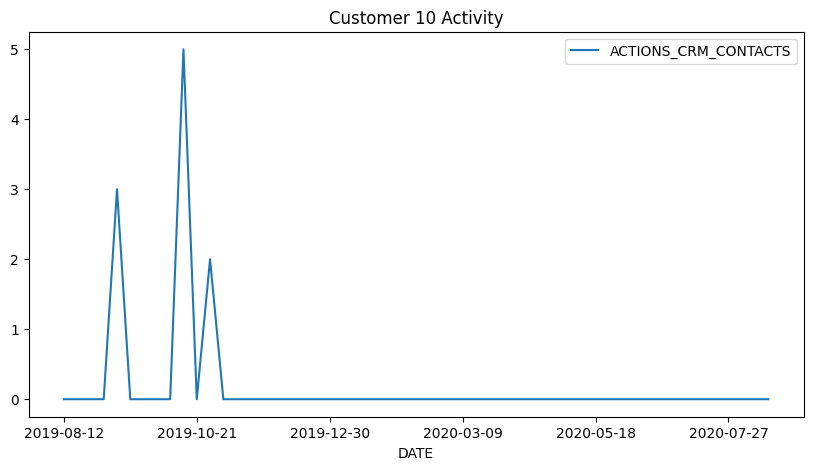

In [322]:
all_activity_df[all_activity_df["id"] == 10].plot.line(x="DATE", y="ACTIONS_CRM_CONTACTS", figsize=(10,5),  
                                                       title="Customer 10 Activity")

<AxesSubplot: title={'center': 'Customer 179 Activity'}, xlabel='DATE'>

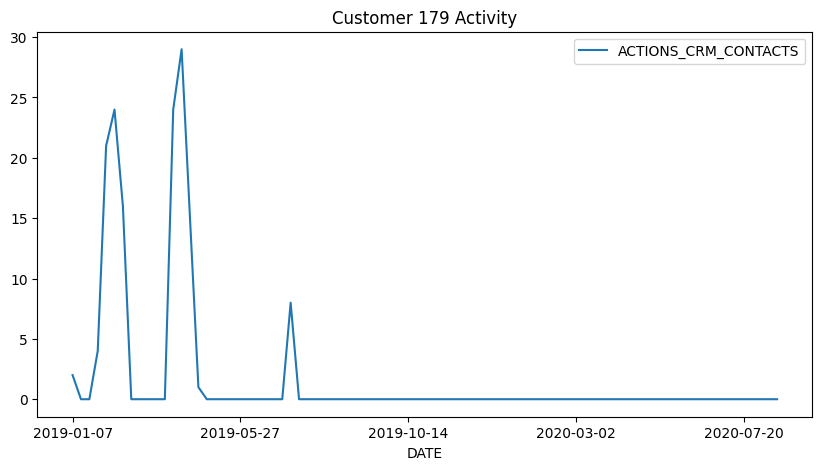

In [319]:
all_activity_df[all_activity_df["id"] == 179].plot.line(x="DATE", y="ACTIONS_CRM_CONTACTS", figsize=(10,5), 
                                                        title="Customer 179 Activity")

<AxesSubplot: title={'center': 'Customer 206 Activity'}, xlabel='DATE'>

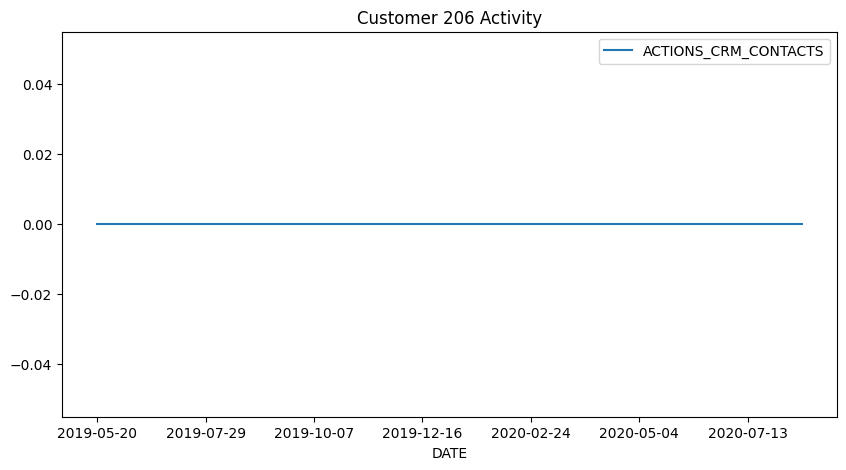

In [323]:
all_activity_df[all_activity_df["id"] == 206].plot.line(x="DATE", y="ACTIONS_CRM_CONTACTS", figsize=(10,5), 
                                                        title="Customer 206 Activity")

<AxesSubplot: title={'center': 'Customer 80 Activity'}, xlabel='DATE'>

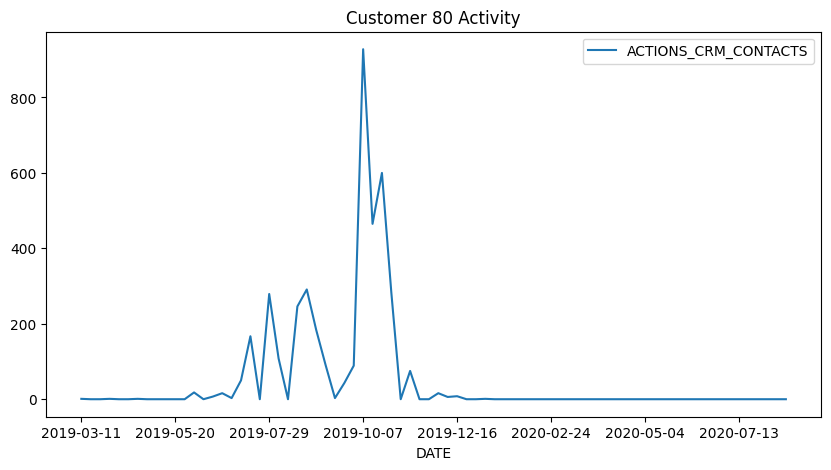

In [324]:
all_activity_df[all_activity_df["id"] == 80].plot.line(x="DATE", y="ACTIONS_CRM_CONTACTS", figsize=(10,5), 
                                                        title="Customer 80 Activity")